- Rodrigo Garcia Martinez
- Mauricio
- Diego
- Roselyn Polanco González
- Cesar Arturo Balam Euan

# Multivariate Linear Regression

In this assignment, you will implement multivariate linear regression to predict the price of houses based on its characteristics.

Suppose you are selling your house and you want to know what a good market price would be. One way to do this is to first collect information on recent houses sold and make a model of housing prices. The file houses.csv contains a training set of housing prices in the city of Valladolid. The first column is the size of the house (in square feet), the second column is the number of bedrooms and the third column is the price of the house. Dataset is like below:

| Size of the house (in square feet) | Number of bedrooms | Price of the house |
|------------------------------------|--------------------|--------------------|
| 2104                               | 3                  | 399900             |
| 1600                               | 3                  | 329900             |
| 2400                               | 3                  | 369000             |


You should fit a multivariate linear regression model using size and bedrooms as variables to predict the price:
* Plot scatterplot of the two variables against price
* Use Scikit-learn to fit the model
* Compute the parameters with the normal equations using np.linalg.inv()
* Compute the parameters with the pseudo-inverse using np.linalg.pinv()
* Plot the fitted surface obtained with any of the previous methods

After that, you should implement the gradient descent algorithm to train a multivariate linear regression model. Try to fit the model with gradient descent and describe the results.

Note that you should standardize the values of the input variables, substracting the mean and dividing by the standard deviation.

For batch gradient descent you should consider the following:

* Define a variable for the learning rate $\alpha$ and try with a default value of 0.01.
* Define a maximum number of iterations with 5000 as default.
* Initialize $\boldsymbol{\theta}$ with random values or zeros.
* Plot J as a function of time (iterations).

Finally, you should implement stochastic and mini-batch gradient descent and compare the parameters obtained with all methods.
- Scikit-learn
- Normal equations
- Pseudo-inverse
- Gradient descent (batch)
- Gradient descent (stochastic)
- Gradient descent (mini-batch)

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler

# Suprimir notación científica en arrays de NumPy para mejor legibilidad
np.set_printoptions(suppress=True)

In [4]:
# Cargar el dataset de "houses.csv"; se asignan nombres de columna manualmente
# porque el CSV no tiene encabezado
houses = pd.read_csv("houses.csv", names=["size", "rooms", "price"])
houses.head()

,size,rooms,price
0,2104,3,399900
1,1600,3,329900
2,2400,3,369000
3,1416,2,232000
4,3000,4,539900


In [5]:
# Separar los features X y la variable objetivo y
# X contiene 'size' y 'rooms'; Y contiene 'price'
X_data = np.array(houses[['size', 'rooms']])       # Matriz de features (n_samples x 2)
y_data = np.array(houses['price']).reshape(-1, 1)  # Vector columna de precios (n_samples x 1) donde reshape cambia la dimensión a una matriz de una sola columna sin modificar los datos
X_data.shape, y_data.shape

((47, 2), (47, 1))

### Standardize data

Sometimes can be useful to standardize the input variables to help with convergence in gradient descent. Note that this may not be necessary for sklearn, normal equations and SVD, but done here just to compare results with gradient descent method.

In [6]:
# Instanciar el escalador y ajustar-transformar las features
# StandardScaler: z = (x - mean) / std
scaler = StandardScaler()
X_data = scaler.fit_transform(X_data)  # Ahora X_data tiene media≈0 y std≈1 por columna
X_data

array([[ 0.13141542, -0.22609337],
       [-0.5096407 , -0.22609337],
       [ 0.5079087 , -0.22609337],
       [-0.74367706, -1.5543919 ],
       [ 1.27107075,  1.10220517],
       [-0.01994505,  1.10220517],
       [-0.59358852, -0.22609337],
       [-0.72968575, -0.22609337],
       [-0.78946678, -0.22609337],
       [-0.64446599, -0.22609337],
       [-0.0771822 ,  1.10220517],
       [-0.000866  , -0.22609337],
       [-0.14077904, -0.22609337],
       [ 3.15099326,  2.4305037 ],
       [-0.9319237 , -0.22609337],
       [ 0.38071502,  1.10220517],
       [-0.86578299, -1.5543919 ],
       [-0.97262567, -0.22609337],
       [ 0.77374348,  1.10220517],
       [ 1.31050078,  1.10220517],
       [-0.29722726, -0.22609337],
       [-0.14332291, -1.5543919 ],
       [-0.50455295, -0.22609337],
       [-0.0491996 ,  1.10220517],
       [ 2.40309445, -0.22609337],
       [-1.14560907, -0.22609337],
       [-0.69025572, -0.22609337],
       [ 0.66817273, -0.22609337],
       [ 0.25352135,

### Include $x_0$ for the bias term.
We want to include the *bias* term in the model, so we include an additional column (variable $x_0$) full of ones.

In [7]:
# Concatenar columna de unos al inicio de la matriz de features
# X resultante tiene forma (n_samples x 3): [1, size_std, rooms_std]
X = np.c_[np.ones(X_data.shape[0]), X_data]
X

array([[ 1.        ,  0.13141542, -0.22609337],
       [ 1.        , -0.5096407 , -0.22609337],
       [ 1.        ,  0.5079087 , -0.22609337],
       [ 1.        , -0.74367706, -1.5543919 ],
       [ 1.        ,  1.27107075,  1.10220517],
       [ 1.        , -0.01994505,  1.10220517],
       [ 1.        , -0.59358852, -0.22609337],
       [ 1.        , -0.72968575, -0.22609337],
       [ 1.        , -0.78946678, -0.22609337],
       [ 1.        , -0.64446599, -0.22609337],
       [ 1.        , -0.0771822 ,  1.10220517],
       [ 1.        , -0.000866  , -0.22609337],
       [ 1.        , -0.14077904, -0.22609337],
       [ 1.        ,  3.15099326,  2.4305037 ],
       [ 1.        , -0.9319237 , -0.22609337],
       [ 1.        ,  0.38071502,  1.10220517],
       [ 1.        , -0.86578299, -1.5543919 ],
       [ 1.        , -0.97262567, -0.22609337],
       [ 1.        ,  0.77374348,  1.10220517],
       [ 1.        ,  1.31050078,  1.10220517],
       [ 1.        , -0.29722726, -0.226

Here we also transform the target variable $y$ to thousand of dollars. This is also not required, but done here for convenience.

In [8]:
# Convertir precios a miles de dólares para trabajar con números más manejables
# Esto no afecta el modelo, solo facilita la interpretación de theta
y = y_data / 1000
y

array([[399.9  ],
       [329.9  ],
       [369.   ],
       [232.   ],
       [539.9  ],
       [299.9  ],
       [314.9  ],
       [198.999],
       [212.   ],
       [242.5  ],
       [239.999],
       [347.   ],
       [329.999],
       [699.9  ],
       [259.9  ],
       [449.9  ],
       [299.9  ],
       [199.9  ],
       [499.998],
       [599.   ],
       [252.9  ],
       [255.   ],
       [242.9  ],
       [259.9  ],
       [573.9  ],
       [249.9  ],
       [464.5  ],
       [469.   ],
       [475.   ],
       [299.9  ],
       [349.9  ],
       [169.9  ],
       [314.9  ],
       [579.9  ],
       [285.9  ],
       [249.9  ],
       [229.9  ],
       [345.   ],
       [549.   ],
       [287.   ],
       [368.5  ],
       [329.9  ],
       [314.   ],
       [299.   ],
       [179.9  ],
       [299.9  ],
       [239.5  ]])

### Plot the data

Now that we have our data prepared, let's plot the independent variables (features) along with the dependent variable (target).

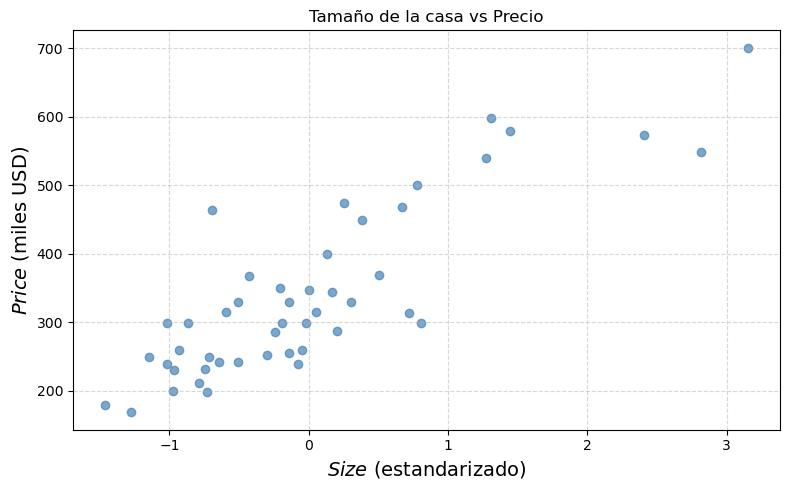

In [9]:
# Crear figura
plt.figure(figsize=(8, 5))

# Scatter plot de size (estandarizado) vs precio
plt.scatter(X[:, 1], y, color='steelblue', alpha=0.7)

# Etiquetas y título
plt.xlabel("$Size$ (estandarizado)", fontsize=14)
plt.ylabel("$Price$ (miles USD)", fontsize=14)
plt.title("Tamaño de la casa vs Precio")

# Cuadrícula, ajuste de márgenes y mostrar
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

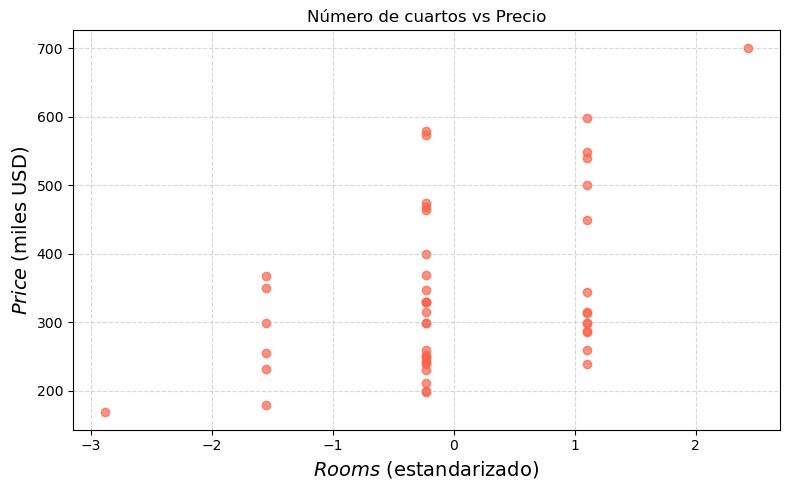

In [10]:
# Crear figura
plt.figure(figsize=(8, 5))

# Scatter plot de rooms (estandarizado) vs precio
plt.scatter(X[:, 2], y, color='tomato', alpha=0.7)

# Etiquetas y título
plt.xlabel("$Rooms$ (estandarizado)", fontsize=14)
plt.ylabel("$Price$ (miles USD)", fontsize=14)
plt.title("Número de cuartos vs Precio")

# Cuadrícula, ajuste de márgenes y mostrar
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

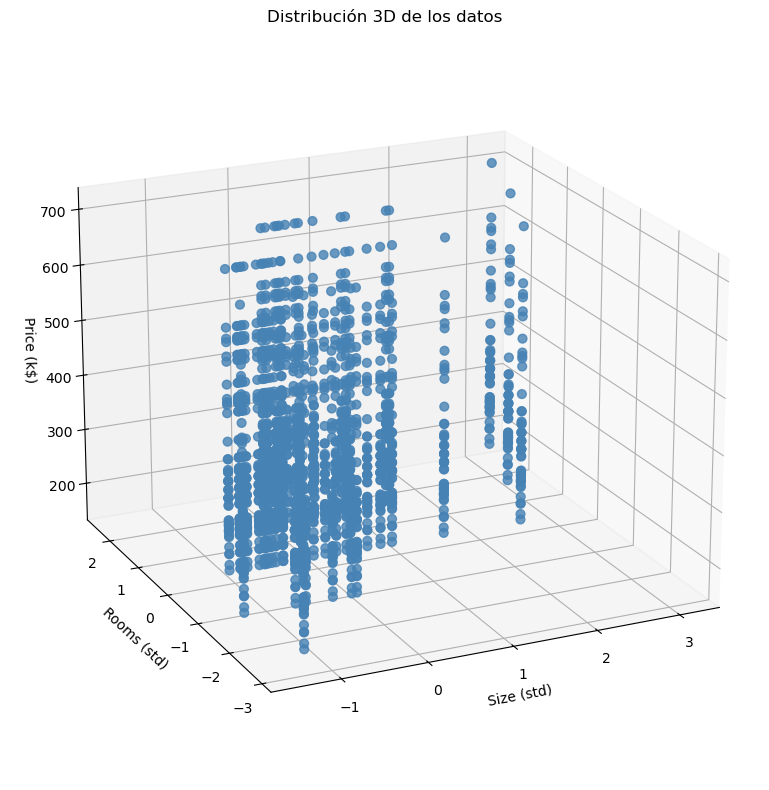

In [11]:
# Crear figura 3D
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Scatter 3D: size (eje X), rooms (eje Y), precio (eje Z)
ax.scatter(X[:, 1], X[:, 2], y, c='steelblue', s=40, alpha=0.8)

# Etiquetas de cada eje y título
ax.set_xlabel('Size (std)')
ax.set_ylabel('Rooms (std)')
ax.set_zlabel('Price (k$)')
ax.set_title('Distribución 3D de los datos')

# Ángulo de cámara: elevación=20°, azimut=245°
ax.view_init(20, 245)

# Ajuste de márgenes y mostrar
plt.tight_layout()
plt.show()

### 1. Scikit-learn

In [12]:
lr = LinearRegression(fit_intercept=False)
lr.fit(X, y)
print(lr.intercept_, lr.coef_)

0.0 [[340.41265957 109.44779647  -6.57835485]]


$\hat{y} = 340.4127 + 109.4478 x_1 - 6.5784 x_2$

In [13]:
lr.predict(X)

array([[356.28311034],
       [286.12093063],
       [397.48946985],
       [269.24418573],
       [472.27785515],
       [330.97902102],
       [276.93302615],
       [262.03748403],
       [255.49458235],
       [271.36459919],
       [324.71454069],
       [341.80520024],
       [326.4920261 ],
       [669.29321223],
       [239.90298686],
       [374.83038333],
       [255.87996102],
       [235.44824529],
       [417.84648161],
       [476.59338604],
       [309.36911319],
       [334.95162386],
       [286.67777333],
       [327.77717552],
       [604.91337413],
       [216.51559363],
       [266.35301492],
       [415.03001477],
       [369.64733504],
       [430.48239959],
       [328.13030084],
       [220.07056445],
       [338.63560809],
       [500.0877366 ],
       [306.75636374],
       [263.42959077],
       [235.86587731],
       [351.4429901 ],
       [641.41882408],
       [355.61931032],
       [303.76843288],
       [374.93734066],
       [411.9996333 ],
       [230

### Plot the data

In [14]:
theta_hat = lr.coef_.T
theta_hat

array([[340.41265957],
       [109.44779647],
       [ -6.57835485]])

In [15]:
size_points, rooms_points = np.meshgrid([np.min(X[:,1]), np.max(X[:,1])],[np.min(X[:,2]), np.max(X[:,2])])
size_points, rooms_points

(array([[-1.46104938,  3.15099326],
        [-1.46104938,  3.15099326]]),
 array([[-2.88269044, -2.88269044],
        [ 2.4305037 ,  2.4305037 ]]))

In [16]:
price_points = theta_hat[0] + theta_hat[1] * size_points + theta_hat[2] * rooms_points

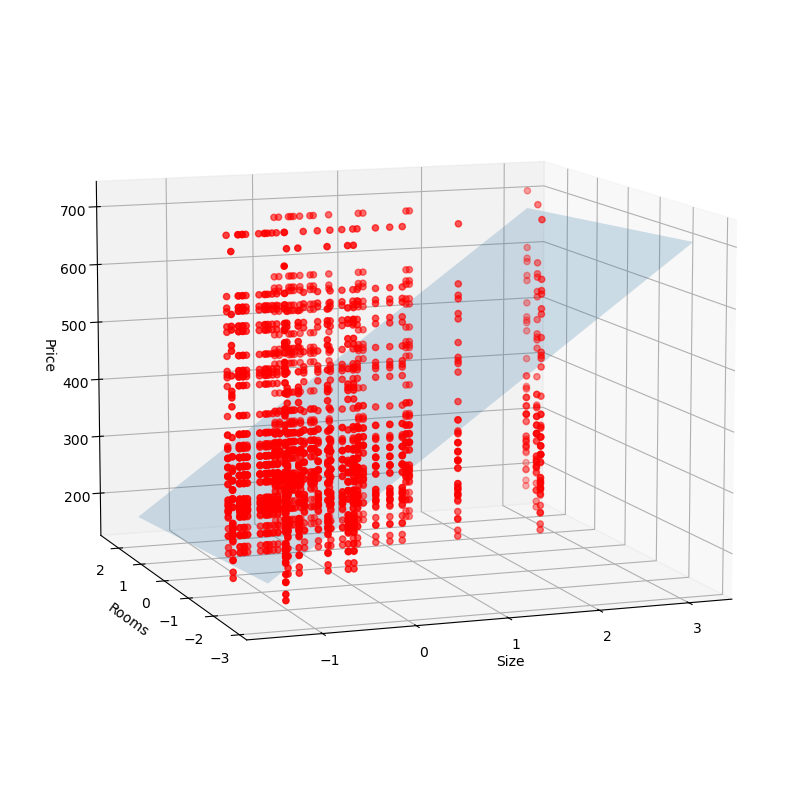

In [17]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(X[:,1], X[:,2], y, c='r')
ax.set_xlabel('Size')
ax.set_ylabel('Rooms')
ax.set_zlabel('Price')
ax.plot_surface(size_points, rooms_points, price_points, alpha=0.2)
ax.view_init(10, 250)

In [18]:
import plotly.express as px
import plotly.graph_objects as go

fig_layout = go.Layout(title='Fitted model', autosize=True, width=800, height=800,
                       scene = dict(xaxis=dict(title='Size'),
                                    yaxis=dict(title='Rooms'),
                                    zaxis=dict(title='Price')))

fig = px.scatter_3d(x=X[:,1].ravel(), y=X[:,2].ravel(), z=y.ravel())
fig.update_traces(marker=dict(size=3))
fig.update_layout(fig_layout)
fig.add_traces(go.Surface(x=size_points, y=rooms_points, z=price_points, opacity=0.2))

fig.show()

### 2. Normal equation

Intercept: [340.41265957] | Coeficient: [array([109.44779647]), array([-6.57835485])]


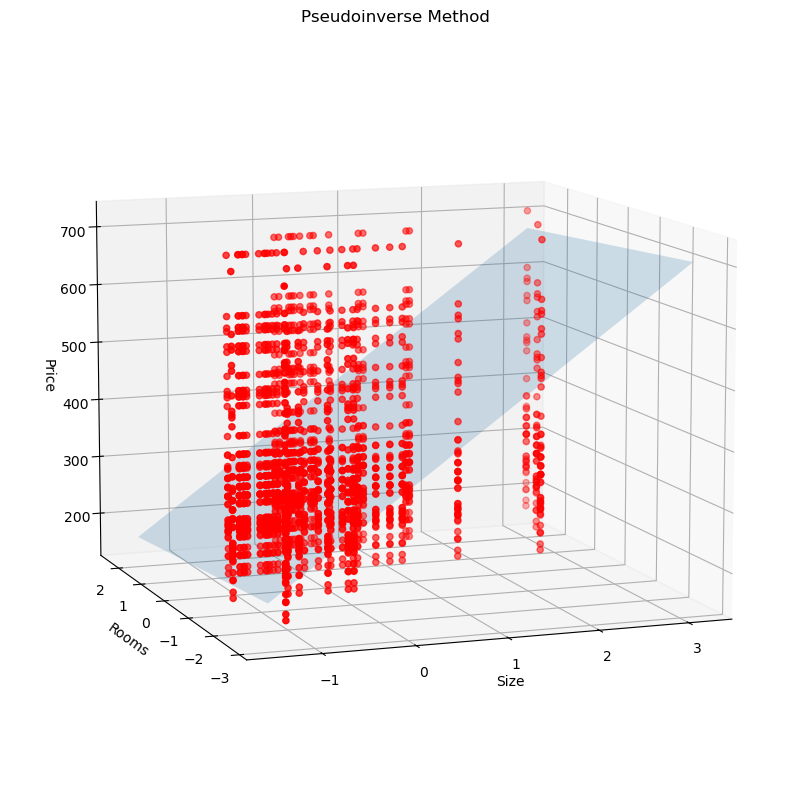

In [19]:
# Your code
theta = np.linalg.inv(X.T.dot(X)).dot(X.T).dot(y)
intercept, *coef = theta
print(f"Intercept: {intercept} | Coeficient: {coef}")

size_points, rooms_points = np.meshgrid([np.min(X[:,1]), np.max(X[:,1])],[np.min(X[:,2]), np.max(X[:,2])])
price_points = theta_hat[0] + theta_hat[1] * size_points + theta_hat[2] * rooms_points

fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(X[:,1], X[:,2], y, c='r')
ax.set_xlabel('Size')
ax.set_ylabel('Rooms')
ax.set_zlabel('Price')
ax.plot_surface(size_points, rooms_points, price_points, alpha=0.2)
ax.set_title("Pseudoinverse Method")
ax.view_init(10, 250)
plt.show()

### 3. SVD pseudoinverse

In [20]:
# Your code

### 4. Gradient descent (batch)

In [21]:
# Your code

### 5. Gradient descent (stochastic)

In [22]:
# Your code

### 6. Gradient descent (mini-batch)

Explicación: 

In [23]:
def minibatch_gradient_descent(X, y, alpha=0.01, n_iter=5000, batch_size=8, random_state=42):
    """
    Implementa Mini-Batch Gradient Descent para regresión lineal.
    En cada iteración usa un subconjunto de tamaño batch_size.
    
    Args:
        X            : Matriz de features con bias (n x p)
        y            : Vector objetivo (n x 1)
        alpha        : Tasa de aprendizaje
        n_iter       : Número de iteraciones
        batch_size   : Tamaño del mini-batch
        random_state : Semilla para reproducibilidad
    Returns:
        theta        : Parámetros encontrados (p x 1)
        history      : Historial del costo J
    """
    np.random.seed(random_state)            # Fijar semilla para reproducibilidad
    m, p = X.shape                          # m = muestras, p = parámetros
    theta = np.zeros((p, 1))                # Inicializar θ en ceros
    history = []                            # Historial del costo global

    for i in range(n_iter):
        # Seleccionar aleatoriamente 'batch_size' índices del dataset
        indices = np.random.choice(m, size=batch_size, replace=False)  # Sin reemplazo

        # Extraer el mini-batch de features y etiquetas
        X_batch = X[indices, :]             # Sub-matriz de features (batch_size x p)
        y_batch = y[indices]                # Sub-vector objetivo (batch_size x 1)

        # Calcular el gradiente promediado sobre el mini-batch
        residuals = X_batch @ theta - y_batch           # Residuales del mini-batch
        gradient  = (1 / batch_size) * X_batch.T @ residuals  # Gradiente (p x 1)

        theta = theta - alpha * gradient    # Actualización de θ

        # Registrar el costo global para seguimiento
        history.append(cost_function(X, y, theta))

    return theta, history


# Ejecutar Mini-Batch GD con batch_size=8 (aprox. 1/5 del dataset)
theta_mb, history_mb = minibatch_gradient_descent(X, y, alpha=0.01, n_iter=5000, batch_size=8)

print("Parámetros (Mini-Batch GD, batch=8):")
print(f"  θ₀ (bias):  {theta_mb[0][0]:.4f}")
print(f"  θ₁ (size):  {theta_mb[1][0]:.4f}")
print(f"  θ₂ (rooms): {theta_mb[2][0]:.4f}")

mse_mb = mean_squared_error(y, X @ theta_mb)
print(f"MSE (Mini-Batch GD): {mse_mb:.4f}")

NameError: name 'cost_function' is not defined

---
## 7. Comparación de los tres métodos de descenso por gradiente (curvas de costo)

In [ ]:
''' Comparar visualmente las tres curvas de convergencia en la misma gráfica
plt.figure(figsize=(11, 6))

# Cada variante con color e intensidad distintos para diferenciarlas
plt.plot(history_batch, label='Batch GD',     color='steelblue', linewidth=2)
plt.plot(history_mb,    label='Mini-Batch GD (b=8)', color='seagreen',  linewidth=1.5, alpha=0.9)
plt.plot(history_sgd,   label='SGD',          color='tomato',    linewidth=1,   alpha=0.6)

plt.xlabel("Iteración", fontsize=13)
plt.ylabel("Costo $J(\\theta)$", fontsize=13)
plt.title("Comparación de convergencia — Batch vs Mini-Batch vs SGD")
plt.legend(fontsize=12)
plt.grid(True, linestyle='--', alpha=0.4)
plt.tight_layout()
plt.show() '''

---
## 8. Comparación de Parámetros obtenidos con todos los métodos

In [ ]:
'''# Construir un DataFrame comparativo con θ₀, θ₁, θ₂ y el MSE de cada método
results = pd.DataFrame({
    'Método': [
        'Scikit-learn',
        'Ecuación Normal',
        'SVD Pseudoinversa',
        'Batch GD',
        'SGD',
        'Mini-Batch GD'
    ],
    'θ₀ (bias)': [
        theta_sklearn[0][0],
        theta_normal[0][0],
        theta_pinv[0][0],
        theta_batch[0][0],
        theta_sgd[0][0],
        theta_mb[0][0]
    ],
    'θ₁ (size)': [
        theta_sklearn[1][0],
        theta_normal[1][0],
        theta_pinv[1][0],
        theta_batch[1][0],
        theta_sgd[1][0],
        theta_mb[1][0]
    ],
    'θ₂ (rooms)': [
        theta_sklearn[2][0],
        theta_normal[2][0],
        theta_pinv[2][0],
        theta_batch[2][0],
        theta_sgd[2][0],
        theta_mb[2][0]
    ],
    'MSE': [
        mse_sklearn,
        mse_normal,
        mse_pinv,
        mse_batch,
        mse_sgd,
        mse_mb
    ]
})

# Formatear a 4 decimales para lectura limpia
results = results.set_index('Método').round(4)
results'''

---
## Conclusiones

### Sobre la normalización
- **Scikit-learn, Ecuación Normal y SVD:**
- **Batch GD, SGD y Mini-Batch GD:**
### Sobre los parámetros obtenidos

### Sobre la convergencia
- **Batch GD:**
- **Mini-Batch GD:**
- **SGD:**